In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from SafeBayes import SafeBayesLinearRegression

In [2]:
file = "data/avg_price_elec.csv"
data = pd.read_csv(file)

In [3]:
def fourier_basis(X, k_max=50):
    return np.vstack([X] + [np.cos(2*np.pi*k*X) for k in range(k_max)] + [np.sin(2*np.pi*k*X) for k in range(k_max)]).T

def generate_covariate(data, name_y = "price",k_max = 50):
    X = data["time"].to_numpy()
    y = data[name_y].to_numpy()
    y = ( y - np.min(y) ) / ( np.max(y)- np.min(y) ) -.5 # Renormalizing y

    N = len(y)
    X = fourier_basis(X, k_max)
    rng = np.random.default_rng()
    ind = np.arange(N)
    rng.shuffle(ind)
 
    return X[ind[:N//2]],y[ind[:N//2]],X[ind[N//2:]],y[ind[N//2:]], 

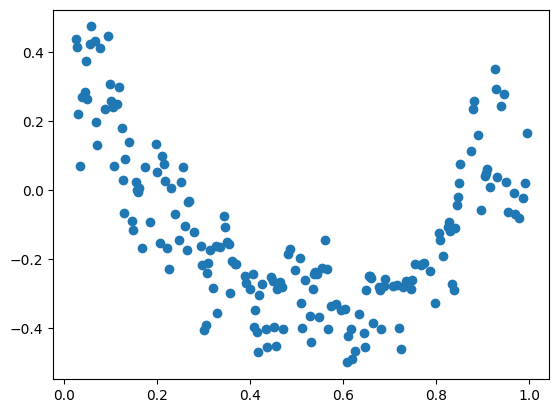

In [4]:
X,y,X_test,y_test = generate_covariate(data, name_y = "charge")
plt.scatter(X[:,0],y)
plt.show()

In [5]:
from scipy.special import psi, softmax #Digamma function useful for RLogLoss
from scipy.stats import invgamma

#Functions to calculate the generalized posterior distributions
#See sec 2.5 of the paper/ sec 3.1 of the longer paper

#------------BETA----------------#
#Covariance matrix of the multivariate normal **posterior** for beta
# Remark : covariance matrix is in fact sigma_sq * Sigman_eta
def Sigman_eta(Sigma, Xn, eta):
  return np.linalg.inv(np.linalg.inv(Sigma) + eta * np.transpose(Xn) @ Xn)
#Expectation of the multivariate normal **posterior** for beta
def betan_eta(Sigma, Xn, eta, beta0, yn):
  return Sigman_eta(Sigma, Xn, eta) @ (np.linalg.inv(Sigma) @ beta0 + eta * np.transpose(Xn) @ yn)


#================================#

#------------SIGMA_SQ----------------#
#Parameters of the Inv-Gamma **posterior** for sigma_sq
def an_eta(a0, eta, n):
  return a0 + (eta * n)/2
def bn_eta(b0, eta, beta, Sigma, Xn, yn):
  betan = betan_eta(Sigma, Xn, eta, beta, yn)
  # sigman = Sigman_eta(sigma, Xn, eta)
  # return b0 + 1/2 * beta.T @ np.linalg.inv(sigma) @ beta + eta/2 * yn.T @ yn -1/2 * betan.T @ np.linalg.inv(sigman) @ betan
  return b0 + (eta / 2) * np.sum(np.square(yn - (Xn @ betan)))
#The induced expectation
def sigman_eta2(a,b):
  return b/(a-1)


def RLogLoss(Xi, yi, eta, i, beta0, a0, b0, Sigma_0):
  if i>=1:
    a = an_eta(a0,eta,i)
    b = bn_eta(b0, eta, beta0, Sigma_0, Xi[:-1], yi[:-1])
    beta = betan_eta(Sigma_0, Xi[:-1], eta, beta0, yi[:-1])
    Sigma = Sigman_eta(Sigma_0, Xi[:-1], eta)
  else:
    a = a0
    b = b0
    beta = beta0
    Sigma = Sigma_0
  return 1/2 * np.log(2 * np.pi * b) - 1/2* psi(a) + 1/2 * (yi[-1] - Xi[-1] @ beta)**2 / (b/a) + 1/2 * Xi[-1].T @ Sigma @ Xi[-1]


def ILogLoss(Xi, yi, eta, i, beta0, a0, b0, Sigma_0):
  if i>=1:
    a = an_eta(a0,eta,i)
    b = bn_eta(b0, eta, beta0, Sigma_0, Xi[:-1], yi[:-1])
    beta = betan_eta(Sigma_0, Xi[:-1], eta, beta0, yi[:-1])
    sigma2 = sigman_eta2(a,b)
  else:
    a = a0
    b = b0
    beta = beta0
    sigma2 = sigman_eta2(a,b)
  return 1/2 * np.log(2 * np.pi * sigma2) - psi(a) + 1/2 * (yi[-1] - Xi[-1] @ beta)**2 / (sigma2)

def square_risk(beta,X_test,y_test):
    return np.mean((y_test - X_test@beta)**2)

In [6]:
def experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=50, sigma2=1/40):
  num = int(k_max/step_size)
  N = len(X)
  etas = np.linspace(0,k_max,num)
  S_R_Log_etas = np.zeros((N-1,num))
  S_I_Log_etas = np.zeros((N-1,num))

  # Constants to get the algorithm going
  beta0 = np.zeros(pmax+1)
  a0 = 1
  b0 = sigma2 * a0
  Sigma_0 = np.eye(pmax+1)

  for eta, k in zip(etas, range(num)):
    for i in range(1,len(X)):
      Xi = X[:(i+1)]
      yi = y[:(i+1)]
      S_R_Log_etas[(i-1):,k] += RLogLoss(Xi, yi, 2**(-eta), i, beta0, a0, b0, Sigma_0)
      S_I_Log_etas[(i-1):,k] += ILogLoss(Xi, yi, 2**(-eta), i, beta0, a0, b0, Sigma_0)


  best_etas_R_Log = etas[np.argmin(S_R_Log_etas,axis=1)]
  best_etas_I_Log = etas[np.argmin(S_I_Log_etas,axis=1)]
  square_risks = np.empty((N-1, 3))
  for k in range(N-1):
    beta_bayes = betan_eta(Sigma_0, X[:k], 1, beta0, y[:k])
    beta_R_Log_safe_bayes = betan_eta(Sigma_0, X[:k], 2**(-best_etas_R_Log[k]), beta0, y[:k])
    beta_I_Log_safe_bayes = betan_eta(Sigma_0, X[:k], 2**(-best_etas_I_Log[k]), beta0, y[:k])
    square_risks[k] = [square_risk(beta_bayes,X_test,y_test),square_risk(beta_R_Log_safe_bayes,X_test,y_test),square_risk(beta_I_Log_safe_bayes,X_test,y_test)]

  return square_risks

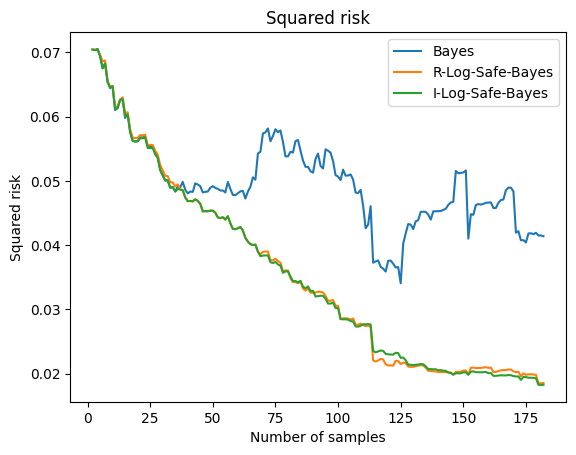

In [7]:
k_fourier_basis = 52 # 52 week in a year

X,y,X_test,y_test = generate_covariate(data, name_y = "charge",k_max=k_fourier_basis)
risk = experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=k_fourier_basis*2, sigma2=1/40)
number_of_samples_used = np.arange(2,len(X)+1)

plt.figure()
plt.plot(number_of_samples_used,risk,label = ["Bayes","R-Log-Safe-Bayes","I-Log-Safe-Bayes"])
plt.xlabel("Number of samples")
plt.ylabel("Squared risk")
plt.legend()
plt.title(f"Squared risk")
plt.title
plt.show()

In [8]:
k_fourier_basis = 52 # 52 week in a year
number_run = 10
all_risk = []
for _ in tqdm(range(number_run)):
    X,y,X_test,y_test = generate_covariate(data, name_y = "charge",k_max=k_fourier_basis)
    all_risk.append(experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=k_fourier_basis*2, sigma2=1/40))
all_risk = np.stack(all_risk)
average_over_run_square_risks = np.mean(all_risk,axis=2)
number_of_samples_used = np.arange(2,len(X)+1)

100%|██████████| 10/10 [03:27<00:00, 20.77s/it]


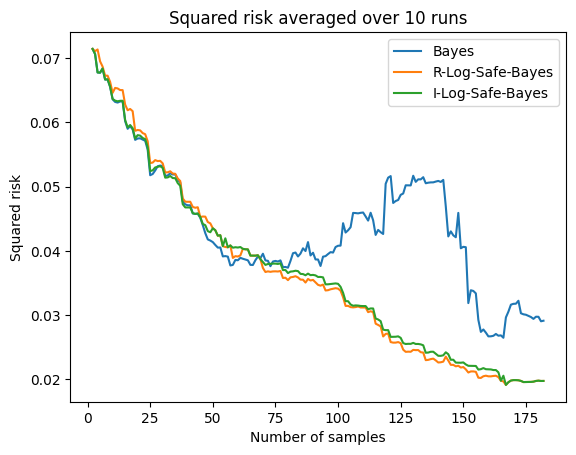

In [9]:
plt.figure()
plt.plot(number_of_samples_used,all_risk[0],label = ["Bayes","R-Log-Safe-Bayes","I-Log-Safe-Bayes"])
plt.xlabel("Number of samples")
plt.ylabel("Squared risk")
plt.legend()
plt.title(f"Squared risk averaged over {number_run} runs")
plt.title
plt.show()

In [10]:
k_fourier_basis = 52 # 52 week in a year
num_samples = 125
X,y,X_test,y_test = generate_covariate(data, name_y = "charge",k_max=k_fourier_basis)
X,y = X[:num_samples],y[:num_samples]
safe_bayes = SafeBayesLinearRegression(loss = 'RLogLoss', a0 = 1, b0 = 1/40, pmax=k_fourier_basis*2)

beta_bayes,_ = safe_bayes.GeneralizedPosteriors(X,y,1)
beta_safe, sigma, eta = safe_bayes.fit(X,y)
print("eta : " , eta)


eta :  0.1088188204120155


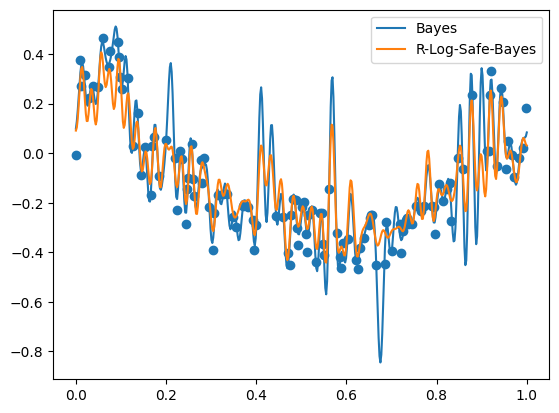

Squared risk standard bayes : 0.0448 -- Squared risk safe bayes : 0.0290


In [11]:
X_plot = np.linspace(0,1,500)
X_plot = fourier_basis(X_plot, k_max=k_fourier_basis)
y_bayes_plot = X_plot @ beta_bayes[0]
y_safe_bayes_plot = X_plot @ beta_safe[0]

plt.figure()
plt.plot(X_plot[:,0],np.vstack([y_bayes_plot,y_safe_bayes_plot]).T,label = ["Bayes","R-Log-Safe-Bayes"])
plt.legend()
plt.scatter(X[:,0],y)
plt.show()

print(f"Squared risk standard bayes : {square_risk(beta_bayes[0],X_test,y_test):.4f} -- Squared risk safe bayes : {square_risk(beta_safe[0],X_test,y_test):.4f}")